<a href="https://colab.research.google.com/github/DarkStarQuantumLab/hft_on_qloud/blob/main/HFT_IBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!python3 -m pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
!python3 -m pip install qiskit_ibm_runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
from qiskit import IBMQ
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator
from qiskit.circuit.quantumcircuit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.extensions.unitary import UnitaryGate
from qiskit.providers.aer import AerSimulator, Aer
import numpy as np


###########
#pass your account token before running
########################################
QiskitRuntimeService.save_account(channel='ibm_quantum', token="", overwrite=True)



# Game Set Up

The payoff matrix is defined as outlined in Jens Eisert's research publication.
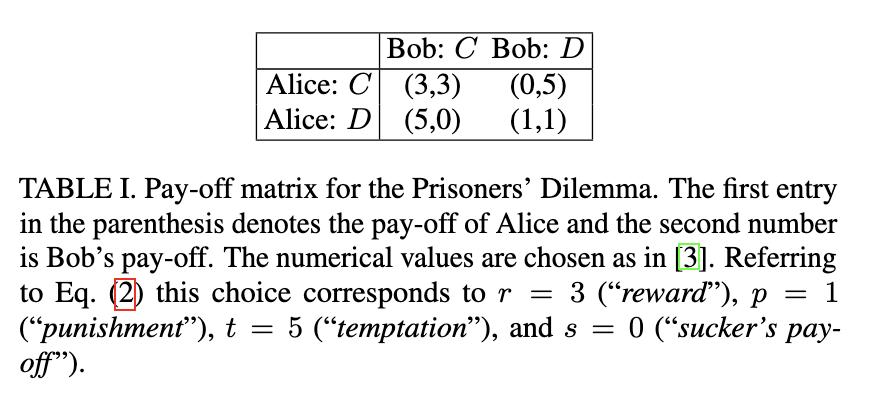

The game at the current stage is limited to the case when of the players has an access to the strategies in the Quantum Space, while other choises to 'compete' only. 




1) Alica has game strategy in Quantum Space defined through the parametrized unitary $U(\phi, \theta)$: 
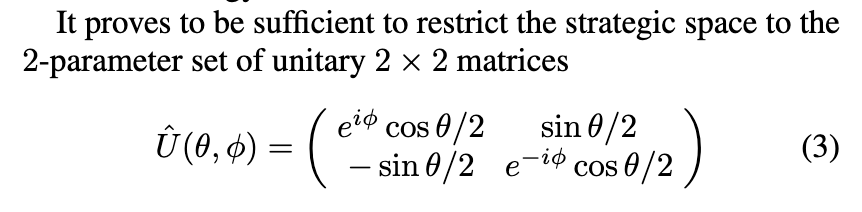

2) Bob always plays a classical strategy "Compete". The unitary is $I$ - the identity matrix.

The qibit in $|0>$ represents "Compete" while the qubit in $|1>$ represents "Defite".

In [22]:

num_players = 2

# define the payoff matrices. Assume, the 1st matrix is Alice's payoff, the secomd matrix is Bob's payoff
payoff_matrix =[[[3, 0],
                [5, 1]],

                [[3, 5],
                [0, 1],]]

# players' matrices
bob = [
    [1, 0],
    [0, 1]]

# bob = [
#     [0, 1],
#     [1, 0],
# ]

# :param [0, PI]
theta = np.pi /2
# :param phi: [0, PI/2]
phi = 0

def build_qcir(theta, phi):
  """
    Set up a quantum game
  """
  alice = [
      [np.exp(1.0j*phi)*np.cos(theta/2), np.sin(theta/2)],
      [-np.sin(theta/2), np.exp(-1.0j*phi)*np.cos(theta/2)],
  ]

  # bob = [
  #   [0, 1],
  #   [1, 0],
  # ]

  qc = QuantumCircuit(num_players)
  # Bell state
  qc.h(0)
  qc.cx(0, 1)
  qc.barrier()

  unitary_alice = UnitaryGate(Operator(alice))
  unitary_bob = UnitaryGate(Operator(bob))

  qc.append(unitary_alice, [0])
  qc.append(unitary_bob, [1])

  qc.barrier()

  qc.cx(0, 1)
  qc.h(0)
  
  
  return qc

In [23]:
# define the simulator
simulator = Aer.get_backend('statevector_simulator')

Execute the game for a several parameters $\phi, \theta$.

In [24]:
# calculating payoffs

def get_payoff(counts):
  """
    Calculates the reward for the palyers after the game ends.
  """
  payoff_bob = []
  payoff_alice = []

  for strategy, prob in counts.items():
    strategy_bob = int(strategy[0])
    strategy_alice = int(strategy[1])

    # print(strategy, prob, strategy_bob, strategy_alice)
    # print('payoff_matrix[1][strategy_bob][0] = ', payoff_matrix[0][strategy_bob][strategy_alice])
    # print('payoff_matrix[0][strategy_alice][0] = ', payoff_matrix[0][strategy_alice][strategy_bob])
    payoff_bob.append(prob * payoff_matrix[0][strategy_bob][strategy_alice])
    payoff_alice.append(prob * payoff_matrix[0][strategy_alice][strategy_bob])

  return sum(payoff_alice), sum(payoff_bob)

In [25]:
from qiskit.execute_function import execute

payoff_B = []

for phi in np.linspace(0, np.pi/2, 4):
  for theta in np.linspace(0, np.pi, 4):
    qc = build_qcir(theta, phi)
    results = execute(qc, simulator, shots=1024).result().get_counts()
    payoff_alice, payoff_bob = get_payoff(results)
    print("theta = {}, phi = {}, results = {}, Alice's payoff {}, Bob's payoff {}".format(theta, phi, results, payoff_alice, payoff_bob))
    print("Next Game")

    

theta = 0.0, phi = 0.0, results = {'00': 1.0}, Alice's payoff 3.0, Bob's payoff 3.0
Next Game
theta = 1.0471975511965976, phi = 0.0, results = {'00': 0.75, '11': 0.25}, Alice's payoff 2.5, Bob's payoff 2.5
Next Game
theta = 2.0943951023931953, phi = 0.0, results = {'00': 0.25, '11': 0.75}, Alice's payoff 1.5, Bob's payoff 1.5
Next Game
theta = 3.141592653589793, phi = 0.0, results = {'11': 1.0}, Alice's payoff 1.0, Bob's payoff 1.0
Next Game
theta = 0.0, phi = 0.5235987755982988, results = {'00': 0.75, '01': 0.25}, Alice's payoff 3.5, Bob's payoff 2.25
Next Game
theta = 1.0471975511965976, phi = 0.5235987755982988, results = {'00': 0.5625, '01': 0.1875, '11': 0.25}, Alice's payoff 2.875, Bob's payoff 1.9375
Next Game
theta = 2.0943951023931953, phi = 0.5235987755982988, results = {'00': 0.1875, '01': 0.0625, '11': 0.75}, Alice's payoff 1.625, Bob's payoff 1.3125
Next Game
theta = 3.141592653589793, phi = 0.5235987755982988, results = {'11': 1.0}, Alice's payoff 1.0, Bob's payoff 1.0
Ne

Execute for the specific value of parameters

In [26]:
# theta = 1.0471975511965976, phi = 0.5235987755982988, results = {'00': 0.5625, '01': 0.1875, '11': 0.25}

qc = build_qcir(theta = 1.0471975511965976, phi = 0.5235987755982988)

job = simulator.run(qc, shots=2048)
result = job.result()
outputstate = result.get_statevector(qc, decimals=3)
print(outputstate)

Statevector([ 0.75+0.j   , -0.  +0.433j,  0.  +0.j   ,  0.5 -0.j   ],
            dims=(2, 2))


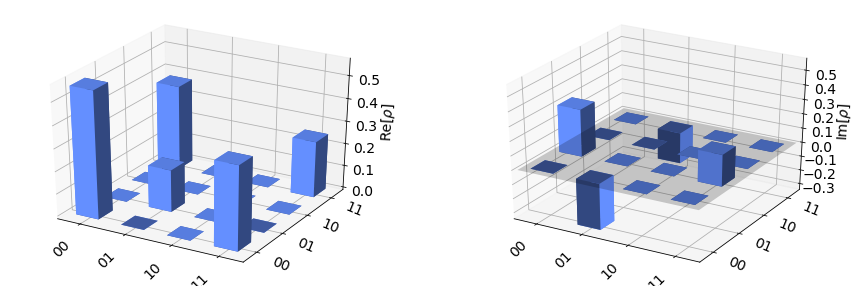

In [27]:
from qiskit.visualization import plot_state_city
plot_state_city(outputstate)



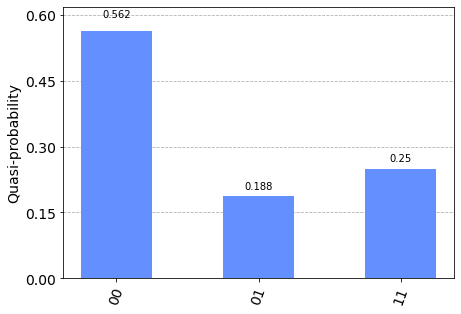

In [28]:
from qiskit.visualization import plot_histogram
counts = result.get_counts()
plot_histogram(counts)



Note, that Qiskit produces the reverse bitstring. For example, the strategy represented by the bitstring "01" means that Alice chooses "1" (D) and Bob chooses "0" (C).

In [29]:
# probabilities of a certain outcome
counts

{'00': 0.5625, '01': 0.1875, '11': 0.25}

In [30]:
def build_qcir_full(theta1, phi1, theta2, phi2):
  """
    Set up a quantum game. Both players have access to quantum strategies space
  """
  alice = [
      [np.exp(1.0j*phi1)*np.cos(theta1/2), np.sin(theta1/2)],
      [-np.sin(theta1/2), np.exp(-1.0j*phi1)*np.cos(theta1/2)],
  ]

  bob = [
      [np.exp(1.0j*phi2)*np.cos(theta2/2), np.sin(theta2/2)],
      [-np.sin(theta2/2), np.exp(-1.0j*phi2)*np.cos(theta2/2)],
  ]


  qc = QuantumCircuit(num_players)
  qc.h(0)
  qc.cx(0, 1)
  qc.barrier()

  unitary_alice = UnitaryGate(Operator(alice))
  unitary_bob = UnitaryGate(Operator(bob))

  qc.append(unitary_alice, [0])
  qc.append(unitary_bob, [1])

  qc.barrier()

  qc.cx(0, 1)
  qc.h(0)
  
  
  return qc

In [31]:
alice_wins = 0
bob_wins = 0
draw = 0

for phi1 in np.linspace(0, np.pi/2, 4):
  for theta1 in np.linspace(0, np.pi, 4):
    for phi2 in np.linspace(0, np.pi/2, 4):
      for theta2 in np.linspace(0, np.pi, 4):
        qc = build_qcir_full(theta1, phi1, theta2, phi2)
        results = execute(qc, simulator, shots=1024).result().get_counts()
        payoff_alice, payoff_bob = get_payoff(results)

        # count winning 
        if payoff_alice > payoff_bob:
          alice_wins += 1
        elif payoff_bob > payoff_alice:
          bob_wins += 1
        else:
          draw += 1
        # print results 
        print("theta_alice = {}, phi_alice = {}, theta_bob = {}, phi_bob = {}".format(theta1, phi1, theta2, phi2 ))
        print("results = {}, Alice's payoff {}, Bob's payoff {}".format(results, payoff_alice, payoff_bob))
        print("Next Game")
        print("===================================================")

theta_alice = 0.0, phi_alice = 0.0, theta_bob = 0.0, phi_bob = 0.0
results = {'00': 1.0}, Alice's payoff 3.0, Bob's payoff 3.0
Next Game
theta_alice = 0.0, phi_alice = 0.0, theta_bob = 1.0471975511965976, phi_bob = 0.0
results = {'00': 0.75, '11': 0.25}, Alice's payoff 2.5, Bob's payoff 2.5
Next Game
theta_alice = 0.0, phi_alice = 0.0, theta_bob = 2.0943951023931953, phi_bob = 0.0
results = {'00': 0.25, '11': 0.75}, Alice's payoff 1.5, Bob's payoff 1.5
Next Game
theta_alice = 0.0, phi_alice = 0.0, theta_bob = 3.141592653589793, phi_bob = 0.0
results = {'11': 1.0}, Alice's payoff 1.0, Bob's payoff 1.0
Next Game
theta_alice = 0.0, phi_alice = 0.0, theta_bob = 0.0, phi_bob = 0.5235987755982988
results = {'00': 0.75, '01': 0.25}, Alice's payoff 3.5, Bob's payoff 2.25
Next Game
theta_alice = 0.0, phi_alice = 0.0, theta_bob = 1.0471975511965976, phi_bob = 0.5235987755982988
results = {'00': 0.5625, '01': 0.1875, '11': 0.25}, Alice's payoff 2.875, Bob's payoff 1.9375
Next Game
theta_alice = 0

In [32]:
print("Alice wins in {} games. Bob wins in {} games. Draw {}.". format(alice_wins, bob_wins, draw))

Alice wins in 61 games. Bob wins in 137 games. Draw 58.


In [55]:
qc = QuantumCircuit(2)

matrix =[[1.0j, 0], [0, -1.0j]]
gate = UnitaryGate(Operator(matrix))
bob = UnitaryGate(Operator(matrix))

qc.h(0)
qc.cx(0,1)
qc.append(gate, [0])
qc.append(gate, [1])
# qc.x(1)
qc.cx(0,1)
qc.h(0)

results = execute(qc, simulator, shots=1024).result().get_counts()

In [56]:
results

{'00': 1.0}